In [1]:
import pandas as pd
import numpy as np
import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from sklearn.metrics import fbeta_score
import xgboost
import shap
from scipy import fftpack
import scipy
from scipy.signal import butter, lfilter
# load JS visualization code to notebook
shap.initjs()

In [2]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [3]:
tsfresh_df = pd.read_csv("../../data/interim/tsfresh_train.csv")

X = tsfresh_df.drop(columns = ["y", "Participant"])

y = tsfresh_df["y"]

In [5]:
model, score, shap_values, X_train = run_xgboost_experiment(X, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [6]:
score

0.9643288996372428

In [9]:
shap_df = make_shap_df(shap_values, X)

In [10]:
shap_df

,feature,SHAP,rank
722,0__standard_deviation,0.601663,1.0
20,"0__agg_linear_trend__f_agg_""mean""__chunk_len_1...",0.569376,2.0
40,"0__agg_linear_trend__f_agg_""min""__chunk_len_5_...",0.516465,3.0
59,0__ar_coefficient__k_10__coeff_1,0.381585,4.0
28,"0__agg_linear_trend__f_agg_""mean""__chunk_len_5...",0.267815,5.0
...,...,...,...
230,"0__fft_coefficient__coeff_12__attr_""abs""",0.001067,163.0
113,"0__change_quantiles__f_agg_""var""__isabs_False_...",0.001063,164.0
367,"0__fft_coefficient__coeff_43__attr_""angle""",0.000898,165.0
355,"0__fft_coefficient__coeff_40__attr_""angle""",0.000793,166.0


In [16]:
shap_df.loc[lambda x: x["feature"].str.contains("0__fft")].head()

,feature,SHAP,rank
526,"0__fft_coefficient__coeff_7__attr_""abs""",0.154283,13.0
234,"0__fft_coefficient__coeff_13__attr_""abs""",0.150404,14.0
402,"0__fft_coefficient__coeff_51__attr_""abs""",0.127301,18.0
310,"0__fft_coefficient__coeff_30__attr_""abs""",0.118799,19.0
240,"0__fft_coefficient__coeff_14__attr_""imag""",0.090465,28.0


In [18]:
just_fft = X.filter(like="0__fft")

In [20]:
model, score, shap_values, X_train = run_xgboost_experiment(just_fft, y)

In [21]:
score

0.9377070907886018

In [23]:
shap_df = make_shap_df(shap_values, just_fft)

In [24]:
shap_df

,feature,SHAP,rank
268,"0__fft_coefficient__coeff_6__attr_""abs""",0.914823,1.0
312,"0__fft_coefficient__coeff_7__attr_""abs""",0.475227,2.0
3,"0__fft_aggregated__aggtype_""variance""",0.317853,3.0
224,"0__fft_coefficient__coeff_5__attr_""abs""",0.306343,4.0
188,"0__fft_coefficient__coeff_51__attr_""abs""",0.299271,5.0
...,...,...,...
209,"0__fft_coefficient__coeff_56__attr_""angle""",0.001683,137.0
243,"0__fft_coefficient__coeff_63__attr_""real""",0.001656,138.0
74,"0__fft_coefficient__coeff_25__attr_""imag""",0.001551,139.0
329,"0__fft_coefficient__coeff_83__attr_""angle""",0.001337,140.0


In [29]:
shap_df[lambda x: x["feature"].str.contains("aggregated")]

,feature,SHAP,rank
3,"0__fft_aggregated__aggtype_""variance""",0.317853,3.0
1,"0__fft_aggregated__aggtype_""kurtosis""",0.045166,38.0
0,"0__fft_aggregated__aggtype_""centroid""",0.020315,59.0
2,"0__fft_aggregated__aggtype_""skew""",0.013451,76.0


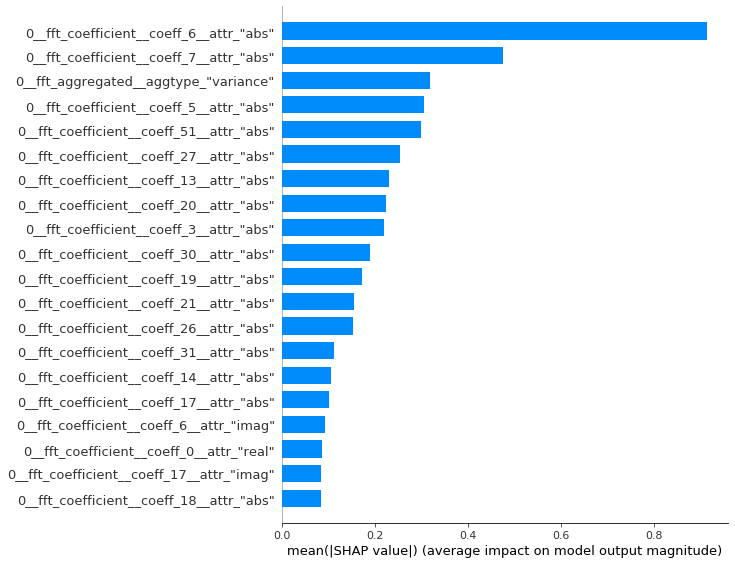

In [32]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [30]:
shap_values.shape

(6375, 404)

In [31]:
just_fft.shape

(7969, 404)

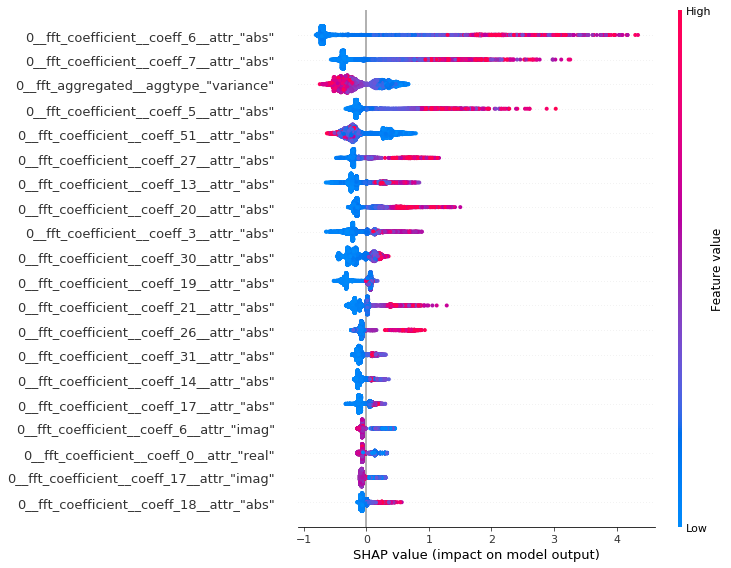

In [33]:
shap.summary_plot(shap_values, X_train)


In [34]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute



In [35]:
features_filtered = select_features(X, y)


In [38]:
X.shape

(7969, 754)

In [39]:
features_filtered.shape

(7969, 314)

In [42]:
model, score, shap_values, X_train = run_xgboost_experiment(features_filtered, y)

In [43]:
score

0.9526592635885447

In [44]:
shap_df = make_shap_df(shap_values, X_train)

In [45]:
shap_df

,feature,SHAP,rank
117,"0__agg_linear_trend__f_agg_""min""__chunk_len_5_...",0.532235,1.0
149,0__standard_deviation,0.503023,2.0
145,"0__agg_linear_trend__f_agg_""mean""__chunk_len_1...",0.456561,3.0
133,0__approximate_entropy__m_2__r_0.1,0.386318,4.0
147,"0__agg_linear_trend__f_agg_""mean""__chunk_len_5...",0.329259,5.0
...,...,...,...
218,0__binned_entropy__max_bins_10,0.001374,139.0
148,"0__agg_linear_trend__f_agg_""min""__chunk_len_10...",0.001223,140.0
132,0__quantile__q_0.9,0.001213,141.0
138,"0__agg_linear_trend__f_agg_""max""__chunk_len_10...",0.001160,142.0


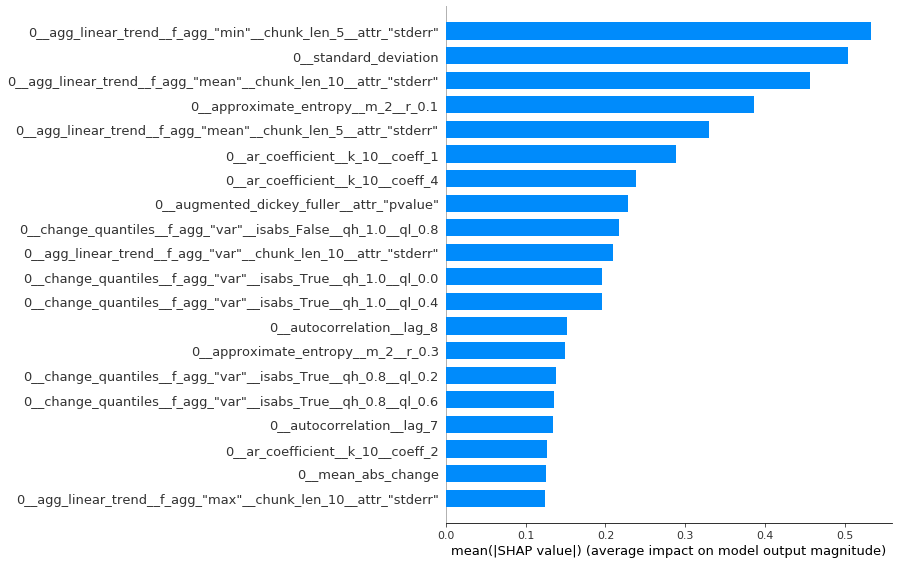

In [46]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

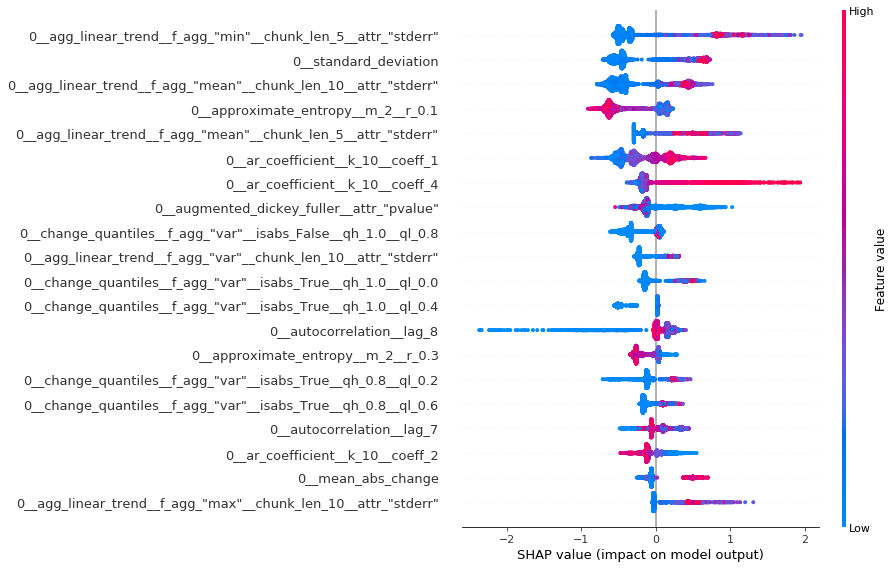

In [49]:
shap.summary_plot(shap_values, X_train)

In [50]:
orig_df = pd.read_csv("../../data/interim/train.csv")

In [51]:
orig_df.shape

(7969, 180)

In [52]:
178/2

89.0